# 01.6 Data Extraction - Creating Location Objects and Events

This notebook processes location sensor data to create behavior events and objects that represent a user's location patterns. The process involves:

1. Identifying when a user enters or exits specific locations (geofences)
2. Detecting when a user is in transit between locations
3. Creating location segments that represent stays at different locations
4. Linking these events and objects to the original sensor data
5. Adding location attributes to behavior events


## Setup

In [2]:
import pandas as pd
import sys
sys.path.append('..')
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# Import project modules
from src.oced.location_objects import LocationEventManager
from src.oced.oced_data_query import OCEDDataQuery

# Load OCEL
First, we load the OCED data and extract the location sensor events. These events contain:
- Timestamp
- Latitude and longitude coordinates
- Additional sensor data (altitude, speed, error)

In [2]:
# Get OCED Data from JSON File
dataQuery = OCEDDataQuery()  
oced_data_file = f"player_107631_oced_data_time_bouts_notifications_stress.json"
data_dict = dataQuery.load_json(oced_data_file)

# Quick look at the data structure
print(f"Number of behavior events: {len(data_dict.get('behaviorEvents', []))}")
print(f"Number of objects: {len(data_dict.get('objects', []))}")

# Diagnostic code to inspect notification events
location_sensor_events = [
    notif for notif in data_dict.get('sensorEvents', [])
    if notif['sensorEventType'] == 'location'
]

print(f"Number of location sensor events: {len(location_sensor_events)}")
location_sensor_events

Number of behavior events: 498
Number of objects: 349
Number of location sensor events: 12903


[{'id': '109085bf-9c19-4c2a-8792-1bfaba12b242',
  'sensorEventType': 'location',
  'time': '2025-05-25T14:02:22',
  'sensorEventTypeAttributes': [{'name': 'latitude',
    'value': 52.09357452392578},
   {'name': 'longitude', 'value': 5.111295223236084},
   {'name': 'altitude', 'value': 46.5},
   {'name': 'speed', 'value': 5.576400089263916},
   {'name': 'error', 'value': 11.0}],
  'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
    'type': 'object',
    'qualifier': 'occurred_on'}],
  'event_type': 'sensor'},
 {'id': 'aecf014a-d1e5-47a2-ae2d-90f4d8ef8567',
  'sensorEventType': 'location',
  'time': '2025-05-25T14:01:22',
  'sensorEventTypeAttributes': [{'name': 'latitude',
    'value': 52.09409713745117},
   {'name': 'longitude', 'value': 5.11100435256958},
   {'name': 'altitude', 'value': 48.59999847412109},
   {'name': 'speed', 'value': 5.612400054931641},
   {'name': 

## Define Location Geofences

Location geofences define the boundaries of important locations. Each geofence has:
- A unique name (e.g., "home", "work")
- Center coordinates (latitude, longitude)
- Radius in meters
These geofences will be used to determine when a user enters or exits these locations.

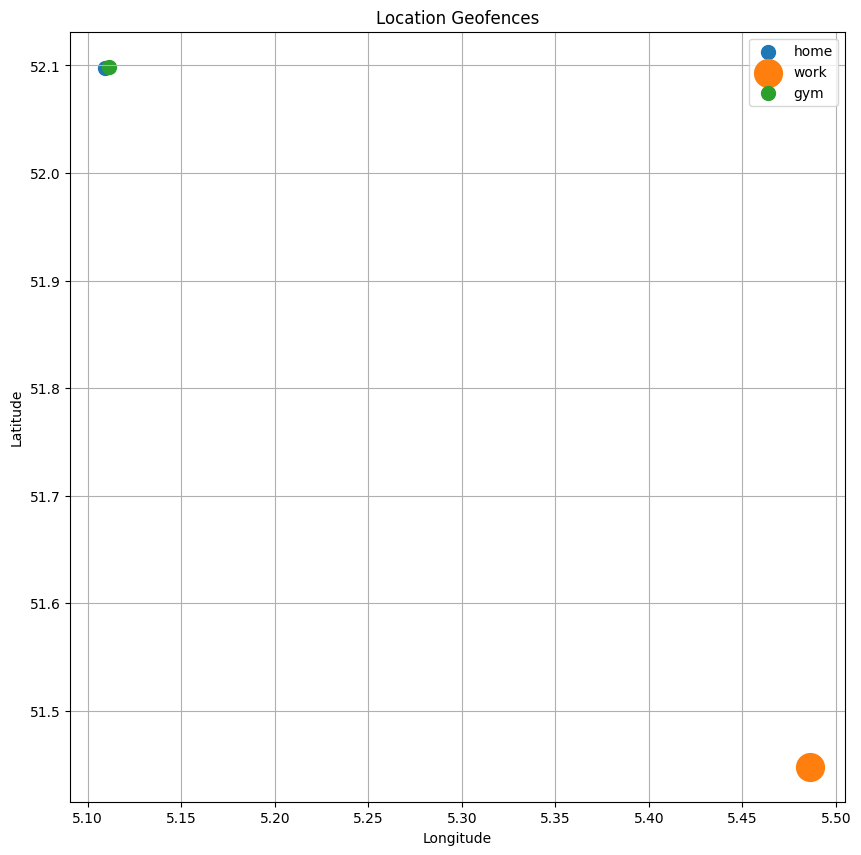

In [3]:
location_geofences = {
    'home': {
        'latitude': 52.09733976415986, 
        'longitude': 5.109440239875549,
        'radius': 50  # meters
    },
    'work': {
        'latitude': 51.44792083437223,
        'longitude': 5.486085861578487,
        'radius': 200
    },
    'gym': {
        'latitude': 52.09881115258374,
        'longitude': 5.11129722583215,
        'radius': 50
    }
}

# Visualize geofences on a map
def plot_geofences(geofences):
    plt.figure(figsize=(10, 10))
    
    # Plot each geofence
    for name, geofence in geofences.items():
        plt.scatter(geofence['longitude'], geofence['latitude'], 
                   label=name, s=geofence['radius']*2)
    
    plt.title('Location Geofences')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_geofences(location_geofences)

## Process Location Sensor Events Data

#### Initializes the LocationEventManager

In [4]:
location_manager = LocationEventManager()

#### Creates necessary event and object types

In [5]:
# Create event types
print("Creating location event types...")
data_with_types = location_manager.create_location_event_type(data_dict)
event_types = [type for type in data_with_types.get('behaviorEventTypes', [])]
event_types

Creating location event types...


[{'name': 'mood',
  'attributes': [{'name': 'valence', 'type': 'number'},
   {'name': 'arousal', 'type': 'number'},
   {'name': 'stress', 'type': 'number'}]},
 {'name': 'notification',
  'attributes': [{'name': 'action', 'type': 'string'}]},
 {'name': 'physical_activity_bout',
  'attributes': [{'name': 'lifecycle', 'type': 'string'},
   {'name': 'bout_type', 'type': 'string'}]},
 {'name': 'location_event',
  'attributes': [{'name': 'lifecycle', 'type': 'string'},
   {'name': 'location_type', 'type': 'string'}]}]

In [6]:
# Create object types
print("Creating location object types...")
data_with_types = location_manager.create_location_object_type(data_with_types)
object_types = [type for type in data_with_types.get('objectTypes', [])]
object_types

Creating location object types...


[{'name': 'player', 'attributes': [{'name': 'id', 'type': 'string'}]},
 {'name': 'intervention',
  'attributes': [{'name': 'goal', 'type': 'string'},
   {'name': 'start_date', 'type': 'string'},
   {'name': 'end_date', 'type': 'string'}]},
 {'name': 'day',
  'attributes': [{'name': 'date', 'type': 'string'},
   {'name': 'day_of_week', 'type': 'string'}]},
 {'name': 'week',
  'attributes': [{'name': 'week_start_date', 'type': 'string'},
   {'name': 'week_number', 'type': 'integer'},
   {'name': 'year', 'type': 'integer'}]},
 {'name': 'physical_activity_bout',
  'attributes': [{'name': 'bout_type', 'type': 'string'}]},
 {'name': 'notification',
  'attributes': [{'name': 'last_action', 'type': 'string'}]},
 {'name': 'stress_self_report',
  'attributes': [{'name': 'stress_value', 'type': 'number'}]},
 {'name': 'location_segment',
  'attributes': [{'name': 'location_type', 'type': 'string'},
   {'name': 'start_time', 'type': 'string'},
   {'name': 'end_time', 'type': 'string'}]}]

#### Processes sensor events to create location events and segments

In [7]:
# Get location sensor events
sensor_events = [event for event in data_with_types.get('sensorEvents', [])
                    if event.get('sensorEventType') == 'location']
print(f"Found {len(sensor_events)} location sensor events")

# Get the user ID from the data
user_objects = [obj for obj in data_with_types.get('objects', []) if obj['type'] == 'player']
if not user_objects:
    raise ValueError("No user object found in the data")
user_id = user_objects[0]['id']
print(f"Using user ID: {user_id}")
    
# Create location events and objects
print("Creating location events and segments...")
extended_data, location_events = location_manager.create_location_events_and_objects(
    data=data_with_types,
    sensor_events=sensor_events,
    user_id=user_id,
    location_geofences=location_geofences,
    transit_distance_threshold=50.0,  # meters
    transit_time_threshold=timedelta(minutes=2),
    min_segment_duration=timedelta(minutes=5),
    invalid_gps_duration_threshold=timedelta(minutes=300),
    default_home_geofence="home"
    )
import pandas as pd
location_events_df = pd.DataFrame(location_events)
location_events_df.to_json('location_events.json', orient='records', indent=4)

# Print statistics
print("\nStatistics:")
print(f"Total location events created: {len(location_events)}")
print(f"Total location segments created: {len(location_manager.location_objects)}")

location_manager.location_objects

Found 12903 location sensor events
Using user ID: d360ac20-326e-4f6f-8113-baa47ef536ef
Creating location events and segments...

Statistics:
Total location events created: 678
Total location segments created: 339


{'313f7458-9e96-416e-a04d-3ec37444d852': {'id': '313f7458-9e96-416e-a04d-3ec37444d852',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-23T00:00:29'},
   {'name': 'start_time',
    'value': '2025-05-23 00:00:29',
    'time': '2025-05-23T00:00:29'},
   {'name': 'end_time',
    'value': '2025-05-23 08:13:27',
    'time': '2025-05-23T08:13:27'}],
  'relationships': [{'type': 'behaviorEvent',
    'id': '115fd3ce-49ef-4aca-90f6-7f6789b144ad',
    'qualifier': 'enters'},
   {'type': 'behaviorEvent',
    'id': '8d579106-c817-4c06-8ef5-c4008d0a38cd',
    'qualifier': 'exits'},
   {'type': 'object',
    'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': '653667bf-f307-4c40-8692-80556139a71e',
    'qualifier': 'occurred_on'}]},
 '58cdbe4a-aec2-4bf1-bab8-6e9dae625943': {'id': '58cdbe4a-aec2-4bf1-bab8-6e9dae625943',
  'type': 'location_segment',
  'attributes': [{'name

## Query and Visualize
1. A function to get events and segments for a specific day
2. A function to create the actual visualization plots

The visualization will show:
- Location events (Entering/Exiting) on a timeline
- Location segments as horizontal bars
- Different colors for different location types
- Time information for each event and segment

In [8]:
def get_day_events(extended_data, date_str):
    """Get all events and segments for a specific day."""
    day_events = {
        'sensor': [],
        'behavior': []
    }
    
    # Filter sensor events
    for event in extended_data.get('sensorEvents', []):
        event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
        if event_time.strftime('%Y-%m-%d') == date_str:
            day_events['sensor'].append(event)
    
    # Filter behavior events (location events)
    for event in extended_data.get('behaviorEvents', []):
        if event['behaviorEventType'] == 'location_event':
            event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
            if event_time.strftime('%Y-%m-%d') == date_str:
                day_events['behavior'].append(event)
    
    # Get location segments
    day_segments = []
    for obj in extended_data.get('objects', []):
        if obj['type'] == 'location_segment':
            start_time = datetime.fromisoformat(next(attr['value'] for attr in obj['attributes'] 
                                                   if attr['name'] == 'start_time'))
            if start_time.strftime('%Y-%m-%d') == date_str:
                day_segments.append(obj)
    
    return day_events, day_segments

def visualize_location_day(extended_data, date_str, location_geofences):
    """Create visualization of location events and segments for a specific day."""
    # Get events and segments for the day
    day_events, day_segments = get_day_events(extended_data, date_str)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
    
    # Plot 1: Location events
    event_types = ['Entering', 'Exiting']
    colors = {'Entering': 'green', 'Exiting': 'red'}
    
    for event in day_events['behavior']:
        event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
        lifecycle = next(attr['value'] for attr in event['attributes'] 
                        if attr['name'] == 'lifecycle')
        location_type = next(attr['value'] for attr in event['attributes'] 
                           if attr['name'] == 'location_type')
        
        # Plot event
        ax1.scatter(event_time, 0, color=colors[lifecycle], marker='|', s=100)
        ax1.text(event_time, 0.1, f"{lifecycle}\n{location_type}", 
                rotation=45, ha='right', va='bottom')
    
    ax1.set_title('Location Events')
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Location segments
    segment_types = sorted(set(segment['attributes'][0]['value'] 
                             for segment in day_segments))
    colors = plt.cm.Set3(np.linspace(0, 1, len(segment_types)))
    color_map = dict(zip(segment_types, colors))
    
    for i, segment in enumerate(day_segments):
        start_time = datetime.fromisoformat(next(attr['value'] for attr in segment['attributes'] 
                                               if attr['name'] == 'start_time'))
        end_time = datetime.fromisoformat(next(attr['value'] for attr in segment['attributes'] 
                                             if attr['name'] == 'end_time'))
        location_type = next(attr['value'] for attr in segment['attributes'] 
                           if attr['name'] == 'location_type')
        
        # Plot segment
        ax2.barh(i, (end_time - start_time).total_seconds() / 3600, 
                left=start_time.hour + start_time.minute/60,
                color=color_map[location_type], alpha=0.7)
        ax2.text(start_time.hour + start_time.minute/60, i, 
                f"{location_type}\n{start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')}",
                va='center')
    
    ax2.set_title('Location Segments')
    ax2.set_xlabel('Hour of Day')
    ax2.set_yticks([])
    ax2.set_xlim(0, 24)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## Diagnostics 

In [10]:
def analyze_location_data(extended_data, location_manager):
    """Analyze location events and segments to understand their relationship."""
    # Get all location events
    location_events = [event for event in extended_data.get('behaviorEvents', [])
                      if event['behaviorEventType'] == 'location_event']
    
    # Count events by type
    entering_events = [e for e in location_events 
                      if next(attr['value'] for attr in e['attributes'] 
                             if attr['name'] == 'lifecycle') == 'Entering']
    exiting_events = [e for e in location_events 
                     if next(attr['value'] for attr in e['attributes'] 
                            if attr['name'] == 'lifecycle') == 'Exiting']
    
    # Get all segments
    segments = [obj for obj in extended_data.get('objects', [])
               if obj['type'] == 'location_segment']
    
    # Analyze relationships
    print(f"Total location events: {len(location_events)}")
    print(f"  - Entering events: {len(entering_events)}")
    print(f"  - Exiting events: {len(exiting_events)}")
    print(f"Total location segments: {len(segments)}")
    
    # Check for orphaned events (events not linked to segments)
    orphaned_events = []
    for event in location_events:
        event_id = event['id']
        is_linked = False
        for segment in segments:
            if any(rel['behaviorEvent'] == event_id 
                  for rel in segment.get('relationships', [])):
                is_linked = True
                break
        if not is_linked:
            orphaned_events.append(event)
    
    print(f"\nOrphaned events (not linked to any segment): {len(orphaned_events)}")
    if orphaned_events:
        print("Example orphaned event:")
        print(json.dumps(orphaned_events[0], indent=2))
    
    # Check for segments with missing events
    incomplete_segments = []
    for segment in segments:
        has_enter = False
        has_exit = False
        for rel in segment.get('relationships', []):
            if rel['type'] == 'starts_with':
                has_enter = True
            elif rel['type'] == 'ends_with':
                has_exit = True
        if not (has_enter and has_exit):
            incomplete_segments.append(segment)
    
    print(f"\nSegments with missing events: {len(incomplete_segments)}")
    if incomplete_segments:
        print("Example incomplete segment:")
        print(json.dumps(incomplete_segments[0], indent=2))

print("\nAnalyzing location events and segments...")
#analyze_location_data(extended_data, location_manager)


Analyzing location events and segments...


## Add relationships with objects and events

#### Add relationships to Physical Activity Bout Objects and Events

In [11]:
# Get all PA bout objects from extended_data
pa_bout_objects = [
    obj for obj in extended_data.get('objects', [])
    if obj['type'] == 'physical_activity_bout'  # Adjust this if your PA bout type has a different name
]
# First, relate PA bout events to locations and then bout objects to locations
updated_data = location_manager.relate_location_to_pa_bouts(
    extended_data,
    pa_bout_objects
)

Found 132 bouts with associated events
Bout 248a72ae-72ea-40ce-bddd-451e06ef20aa has 2 events
  Event 80983ab6-71e6-41c1-abca-827ec64eb188 relationships: ['starts']
  Event e1aa4c93-2ac0-4a0b-b74d-7f22cafaa71b relationships: ['ends']
Bout 323dd820-44b8-4555-b77c-adb695c87c00 has 2 events
  Event 808b43a4-d89a-4ea1-83a6-4553037c7f3e relationships: ['starts']
  Event cb2d185b-353c-4f5a-82a0-1f0970765d2b relationships: ['ends']
Bout 78cb2a33-69a8-48b2-9bd8-c1d31bfec209 has 2 events
  Event 4323b0f8-40a7-4024-8a2d-ed760daa963f relationships: ['starts']
  Event fee89403-249e-408d-ae2b-56986c86b57f relationships: ['ends']
Bout c7906ca0-2344-4260-948d-7c749f8fcf7b has 2 events
  Event f4f3e354-770b-4a09-90fe-323e729321b7 relationships: ['starts']
  Event 82954aa8-181d-47ff-a02e-ce64adbea99b relationships: ['ends']
Bout 4f786d8a-d0af-4bf0-a20f-b40c4ba0e47e has 2 events
  Event 0fe113b8-7692-43cf-b80e-042b9d461c44 relationships: ['starts']
  Event b5b5837d-6eac-4e96-8160-513a70642bb7 relationsh

In [12]:
# Validation code
print("Validating PA bout to location relationships:")
print("-" * 50)
# Get all PA bout objects
pa_bouts = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'physical_activity_bout'
]
print("PA Bouts objects ++++++++++")
pa_bouts[0]

Validating PA bout to location relationships:
--------------------------------------------------
PA Bouts objects ++++++++++


{'id': '248a72ae-72ea-40ce-bddd-451e06ef20aa',
 'type': 'physical_activity_bout',
 'attributes': [{'name': 'bout_type',
   'value': 'MODERATE-VIGOROUS_PA',
   'time': '2025-05-10T10:18:01.735000'},
  {'name': 'start_time',
   'value': '2025-05-10T10:18:01.735000',
   'time': '2025-05-10T10:18:01.735000'},
  {'name': 'end_time',
   'value': '2025-05-10T10:21:21.695000',
   'time': '2025-05-10T10:21:21.695000'}],
 'relationships': [{'id': '3d508954-d9da-4336-9ac0-4760573e74f6',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'performed_by'},
  {'type': 'object',
   'id': '734c2ee7-9c87-403f-8e15-4121f5a2ef82',
   'qualifier': 'overlaps_with_location'}]}

In [13]:
# Get all PA bout events
pa_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "physical_activity_bout"  # Adjust to match your event type
]
print("PA bouts events ++++++++++ ")
pa_events[0]

PA bouts events ++++++++++ 


{'id': '80983ab6-71e6-41c1-abca-827ec64eb188',
 'behaviorEventType': 'physical_activity_bout',
 'time': '2025-05-10T10:18:01.735000',
 'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'START'},
  {'name': 'bout_type', 'value': 'MODERATE-VIGOROUS_PA'}],
 'relationships': [{'id': '248a72ae-72ea-40ce-bddd-451e06ef20aa',
   'type': 'object',
   'qualifier': 'starts'},
  {'id': '3d508954-d9da-4336-9ac0-4760573e74f6',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'performed_by'},
  {'type': 'object',
   'id': '734c2ee7-9c87-403f-8e15-4121f5a2ef82',
   'qualifier': 'occurred_in_location'}]}

In [14]:
# Get all PA bout events
location_segments = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == "location_segment"  
]
print("events++++++++++ ")
location_segments[:2]

objects ++++++++++ 


[{'id': '313f7458-9e96-416e-a04d-3ec37444d852',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-23T00:00:29'},
   {'name': 'start_time',
    'value': '2025-05-23 00:00:29',
    'time': '2025-05-23T00:00:29'},
   {'name': 'end_time',
    'value': '2025-05-23 08:13:27',
    'time': '2025-05-23T08:13:27'}],
  'relationships': [{'type': 'behaviorEvent',
    'id': '115fd3ce-49ef-4aca-90f6-7f6789b144ad',
    'qualifier': 'enters'},
   {'type': 'behaviorEvent',
    'id': '8d579106-c817-4c06-8ef5-c4008d0a38cd',
    'qualifier': 'exits'},
   {'type': 'object',
    'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': '653667bf-f307-4c40-8692-80556139a71e',
    'qualifier': 'occurred_on'}]},
 {'id': '58cdbe4a-aec2-4bf1-bab8-6e9dae625943',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-20T08:38:53'},


#### Add a location attribute to the physical_activity_bout behaviorEventType

In [15]:
# add location attributes to the events
updated_data = location_manager.add_location_attribute_to_pa_events(
    extended_data=updated_data
)

# Validation code
print("\nDetailed Validation of PA bout events with location attributes:")
print("-" * 50)

# Get all PA bout events
pa_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "physical_activity_bout"
]

pa_events

Added location attribute to physical_activity_bout event type

Location attribute statistics:
Total PA bout events: 264
Events with location attribute: 264
Events without location attribute: 0
Coverage: 100.0%

Detailed Validation of PA bout events with location attributes:
--------------------------------------------------


[{'id': '80983ab6-71e6-41c1-abca-827ec64eb188',
  'behaviorEventType': 'physical_activity_bout',
  'time': '2025-05-10T10:18:01.735000',
  'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'START'},
   {'name': 'bout_type', 'value': 'MODERATE-VIGOROUS_PA'},
   {'name': 'location', 'value': 'invalid'}],
  'relationships': [{'id': '248a72ae-72ea-40ce-bddd-451e06ef20aa',
    'type': 'object',
    'qualifier': 'starts'},
   {'id': '3d508954-d9da-4336-9ac0-4760573e74f6',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': '734c2ee7-9c87-403f-8e15-4121f5a2ef82',
    'qualifier': 'occurred_in_location'}]},
 {'id': 'e1aa4c93-2ac0-4a0b-b74d-7f22cafaa71b',
  'behaviorEventType': 'physical_activity_bout',
  'time': '2025-05-10T10:21:21.695000',
  'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'END'},
   {'name': 'bout_type', 'val

#### Add relationships to Notification Objects and Events

In [16]:
# Get all notification events from extended_data
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == 'notification' 
]
notification_events[:2]

[{'id': 'b75e0192-027a-452e-bc60-661d42c68d79',
  'behaviorEventType': 'notification',
  'time': '2025-05-25T12:59:53.042000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'READ'}],
  'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'a61d3d86-ba05-4fe9-86f1-737f11f1bea4',
    'type': 'object',
    'qualifier': 'reads'}],
  'event_type': 'behavior'},
 {'id': 'c1a5aba3-af33-4ead-a962-1e50b6010de2',
  'behaviorEventType': 'notification',
  'time': '2025-05-25T12:59:33.754000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'}],
  'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'ec33bfca-4063-

In [17]:
# Get all notification objects from extended_data
notification_objects = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'notification' 
]
notification_objects[:2]

[{'id': '70302baa-89b3-48e7-a363-c248313a76bf',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T08:51:55.800000'}],
  'relationships': [{'id': 'f9efdadf-386e-46a3-b654-d9476f18d825',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'}]},
 {'id': '12cc0d6f-e2fa-4a11-8a17-0777b31b4910',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T11:55:11.964000'}],
  'relationships': [{'id': 'f9efdadf-386e-46a3-b654-d9476f18d825',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'}]}]

In [18]:
# Add relationships between notification events/objects and location segments
updated_data = location_manager.relate_notifications_to_locations(
    extended_data=updated_data,
    notification_event_type="notification",  
    notification_object_type="notification" 
)


Notification event to location relationship statistics:
Total notification events: 158
Events with location relationships: 158
Events without location relationships: 0
Coverage: 100.0%
Notification object 70302baa-89b3-48e7-a363-c248313a76bf overlaps with 1 location segments
  Time range: 2025-05-09 08:51:37.242000 to 2025-05-09 08:51:37.242000
  Number of associated events: 1
Notification object 12cc0d6f-e2fa-4a11-8a17-0777b31b4910 overlaps with 1 location segments
  Time range: 2025-05-09 11:55:02.267000 to 2025-05-09 11:55:02.267000
  Number of associated events: 1
Notification object 722a491c-b9ee-4269-8b8f-88ab33952f68 overlaps with 1 location segments
  Time range: 2025-05-09 15:00:37.186000 to 2025-05-09 15:00:37.186000
  Number of associated events: 1
Notification object 83d283ca-1e4e-4402-8926-fb2a884b4522 overlaps with 1 location segments
  Time range: 2025-05-09 18:09:19.983000 to 2025-05-09 18:09:19.983000
  Number of associated events: 1
Notification object 7f415c15-8602-

In [19]:
print("Validating notification event to location relationships:")
print("-" * 50)
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "notification"  # Adjust to match your event type
]
# Get all PA bout objects
notification_objects = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'notification'
]


Validating notification event to location relationships:
--------------------------------------------------


In [20]:
print("Notification events ++++++++++ ")
notification_events[0]

Notification events ++++++++++ 


{'id': 'b75e0192-027a-452e-bc60-661d42c68d79',
 'behaviorEventType': 'notification',
 'time': '2025-05-25T12:59:53.042000',
 'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'READ'}],
 'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
   'type': 'object',
   'qualifier': 'source'},
  {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'a61d3d86-ba05-4fe9-86f1-737f11f1bea4',
   'type': 'object',
   'qualifier': 'reads'},
  {'type': 'object',
   'id': '38643450-f107-48a1-bd35-4dbdbfdc7a1d',
   'qualifier': 'occurred_in_location'}],
 'event_type': 'behavior'}

In [21]:
print("Notification objects ++++++++++ ")
notification_objects[0]

Notification objects ++++++++++ 


{'id': '70302baa-89b3-48e7-a363-c248313a76bf',
 'type': 'notification',
 'attributes': [{'name': 'last_action',
   'value': 'READ',
   'time': '2025-05-09T08:51:55.800000'}],
 'relationships': [{'id': 'f9efdadf-386e-46a3-b654-d9476f18d825',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'received_by'},
  {'type': 'object',
   'id': 'dac51573-5483-4e52-88b3-f18b72c92f1b',
   'qualifier': 'overlaps_with_location'}]}

#### Add location attribute to Notification Events 

In [22]:
# After calling relate_notifications_to_locations
updated_data = location_manager.add_location_attribute_to_notification_events(
    updated_data,
    notification_event_type="notification"  # adjust if your event type is different
)
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "notification"  # Adjust to match your event type
]
print("Notification Events++++++")
notification_events[0]



Added location attribute to notification event type

Location attribute statistics for notification events:
Total notification events: 158
Events with location attribute: 158
Events without location attribute: 0
Coverage: 100.0%
Notification Events++++++


{'id': 'b75e0192-027a-452e-bc60-661d42c68d79',
 'behaviorEventType': 'notification',
 'time': '2025-05-25T12:59:53.042000',
 'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'READ'},
  {'name': 'location', 'value': 'invalid'}],
 'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
   'type': 'object',
   'qualifier': 'source'},
  {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'a61d3d86-ba05-4fe9-86f1-737f11f1bea4',
   'type': 'object',
   'qualifier': 'reads'},
  {'type': 'object',
   'id': '38643450-f107-48a1-bd35-4dbdbfdc7a1d',
   'qualifier': 'occurred_in_location'}],
 'event_type': 'behavior'}

#### Add relationships to Self-report Events and Objects

In [23]:
# Get all notification events from extended_data
mood_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == 'mood' 
]
mood_events[0]

{'id': '67b8d80e-fb50-4037-9c3a-8db93746fc89',
 'behaviorEventType': 'mood',
 'time': '2025-05-25T13:00:00.886000',
 'behaviorEventTypeAttributes': [{'name': 'valence', 'value': 6},
  {'name': 'arousal', 'value': 6},
  {'name': 'stress', 'value': 4}],
 'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
   'type': 'object',
   'qualifier': 'source'},
  {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'b007b627-8e70-4a80-b511-be98b3e2bf3a',
   'type': 'object',
   'qualifier': 'reports_stress'}],
 'event_type': 'behavior'}

In [24]:
# For mood events - this will both add relationships and location attributes
updated_data = location_manager.relate_mood_events_to_locations(
    updated_data,
    mood_event_type="mood"  # adjust if your event type is different
)

# For stress self-report objects
updated_data = location_manager.relate_stress_self_reports_to_locations(
    updated_data,
    stress_object_type="stress_self_report"  # adjust if your object type is different
)


Mood event to location relationship statistics:
Total mood events: 76
Events with location relationships: 52
Events without location relationships: 24
Coverage: 68.4%
Added location attribute to mood event type

Location attribute statistics for mood events:
Total mood events: 76
Events with location attribute: 52
Events without location attribute: 24
Coverage: 68.4%

Stress self-report to location relationship statistics:
Total stress self-report objects: 76
Objects with location relationships: 52
Objects without location relationships: 24
Coverage: 68.4%


In [25]:
mood_events = [event for event in updated_data.get('behaviorEvents', [])
               if event['behaviorEventType'] == "mood"]
mood_events[0]

{'id': '67b8d80e-fb50-4037-9c3a-8db93746fc89',
 'behaviorEventType': 'mood',
 'time': '2025-05-25T13:00:00.886000',
 'behaviorEventTypeAttributes': [{'name': 'valence', 'value': 6},
  {'name': 'arousal', 'value': 6},
  {'name': 'stress', 'value': 4},
  {'name': 'location', 'value': 'invalid'}],
 'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
   'type': 'object',
   'qualifier': 'source'},
  {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'b007b627-8e70-4a80-b511-be98b3e2bf3a',
   'type': 'object',
   'qualifier': 'reports_stress'},
  {'type': 'object',
   'id': '38643450-f107-48a1-bd35-4dbdbfdc7a1d',
   'qualifier': 'occurred_in_location'}],
 'event_type': 'behavior'}

In [26]:
stress_self_report_objects = [obj for obj in updated_data.get('objects', [])
               if obj['type'] == "stress_self_report"]
stress_self_report_objects[0]

{'id': '39c34d2c-02ce-4720-8b38-e9a70009fdf8',
 'type': 'stress_self_report',
 'attributes': [{'name': 'stress_value',
   'value': 6.0,
   'time': '2025-03-20T15:39:28.698000'}],
 'relationships': [{'id': 'f7397705-b95e-4127-9090-32e0297be74a',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
   'type': 'object',
   'qualifier': 'reported_by'}]}

## Save extended OCED to JSON

In [27]:
# Save the extended data
location_manager.save_extended_data(
    filename="player_107631_oced_data_time_bouts_notifications_stress_location.json",  # or any other name you prefer
    extended_data=updated_data,
    compress=False  # Set to True if you want a compressed .json.gz file
)


Saving extended data with:
- 339 location segment objects
- 678 location events (339 segments)
- 688 total objects
- 1176 total behavior events
Saved extended data to: c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\data\transformed\player_107631_oced_data_time_bouts_notifications_stress_location.json
